## Purpose

---

This file is for 'manually' calculating outputs so we can validate the system output.


In [1]:
from math import sin, cos, atan2
import numpy as np
from pyproj import Transformer

In [2]:
EPSG_32633_BALATON = 32633
"""
USE EAST OF VENICE | WEST OF SIÓFOK!
Cartesian 2D CS
- Axes: (E,N)
- Orientations: east, north
- Unit: m
- Coverage: **12°E** and **18°E**, northern hemisphere between equator and 84°N.
"""

WGS84_GPS = 4326
"""
Ellipsoidal 2D CS
- Axes: latitude, longitude
- Orientations: north, east
- Unit: degree
"""

'\nEllipsoidal 2D CS\n- Axes: latitude, longitude\n- Orientations: north, east\n- Unit: degree\n'

In [3]:
# Cell 1: Imports and Setup

# WGS84 to local ENU projection (use lat/lon of origin as reference)
origin_lat, origin_lon = 46.7822, 17.6452  # Boglári kikötő
transformer = Transformer.from_crs(
    WGS84_GPS,
    EPSG_32633_BALATON,
    always_xy=True
)


# Sample lat/lon data
psi_deg = -45.0

# Current position (just east of WP1, close to the line WP1 → WP2)
lat_current = 46.7825
lon_current = 17.6427

# WP1: South-west point
lat_1 = 46.7822
lon_1 = 17.6425

# WP2: North-west point
lat_2 = 46.7828
lon_2 = 17.6425


# Convert to local XY
x_current, y_current = transformer.transform(lon_current, lat_current)
xk_1, yk_1 = transformer.transform(lon_1, lat_1)
xk_2, yk_2 = transformer.transform(lon_2, lat_2)

# Convert heading
psi_current = np.deg2rad(psi_deg)

# Controller parameters
U = 1.1  # [m/s]
k1, k2, k3, k4 = 1.6, 19.92, 2.125, 92.1

Made using [mapcustomizer](https://www.mapcustomizer.com/#)

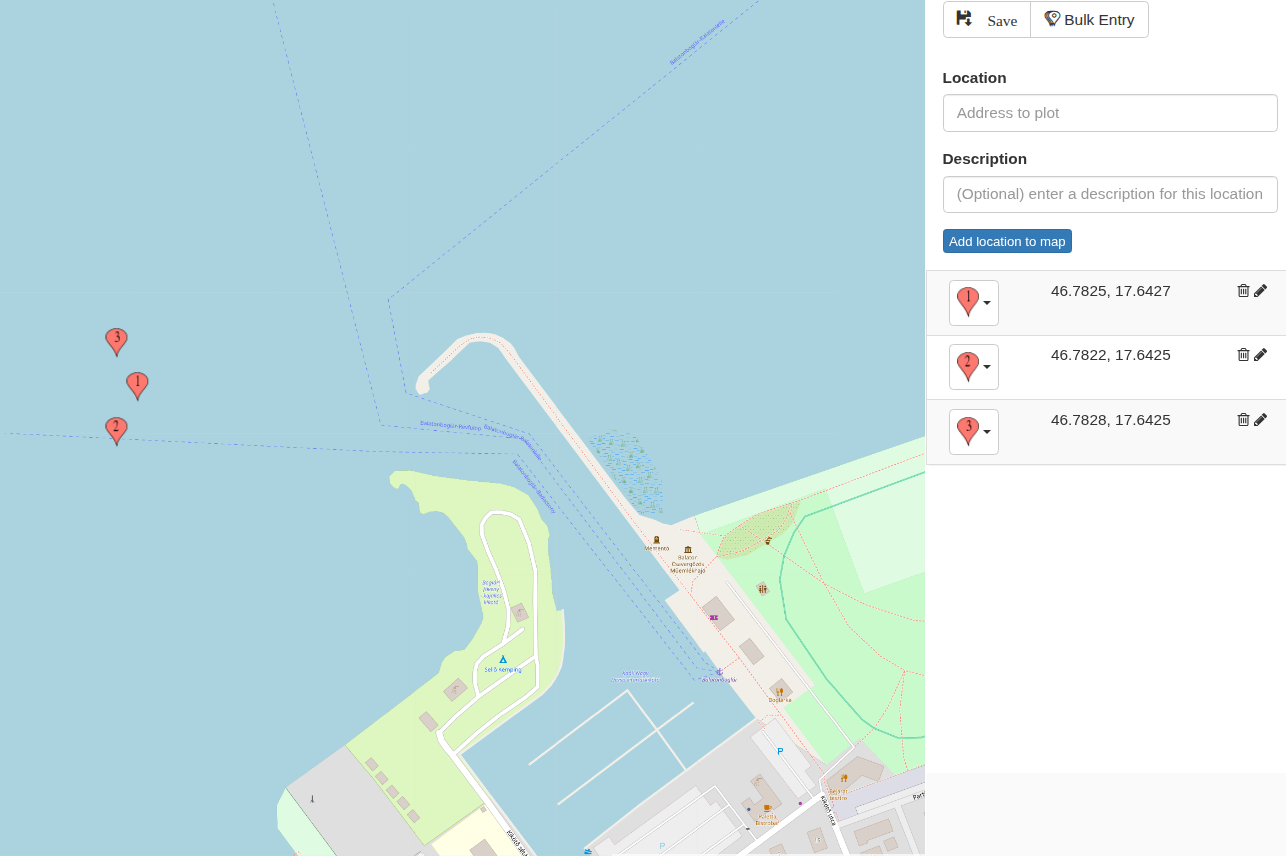


In [4]:
x_current, y_current, np.rad2deg(psi_current)

(701722.2853319473, 5184386.019295096, np.float64(-45.0))

In [5]:
print(f"Current XY: {x_current:.2f}, {y_current:.2f}")
print(f"WP1 XY:     {xk_1:.2f}, {yk_1:.2f}")
print(f"WP2 XY:     {xk_2:.2f}, {yk_2:.2f}")

Current XY: 701722.29, 5184386.02
WP1 XY:     701708.14, 5184352.17
WP2 XY:     701705.90, 5184418.84


In [6]:
# Cell 2: Helper Functions

def heading_to_next_waypoint(x_0, y_0, x_1, y_1):
    """Eq. (4): Heading from point 0 to point 1"""
    dx = x_1 - x_0
    dy = y_1 - y_0

    return atan2(dy, dx)


def cross_track_error(x, y, x_ref, y_ref, psi_k):
    return sin(psi_k) * (x - x_ref) - cos(psi_k) * (y - y_ref)

In [7]:
# 1. Desired heading from waypoint segment
psi_k = heading_to_next_waypoint(xk_1, yk_1, xk_2, yk_2)
np.rad2deg(psi_k)

np.float64(91.92639345217054)

In [8]:
e_psi = psi_current - psi_k
np.rad2deg(e_psi)

np.float64(-136.92639345217054)

In [9]:
# 2. Compute errors

e_y = cross_track_error(x_current, y_current, xk_1, yk_1, psi_k)
int_e_y = 0.1 * e_y  # crude accumulated integral
e_y, int_e_y

(15.274349588257262, 1.5274349588257263)

In [10]:
def control_output(e_psi, de_psi, e_y, int_e_y):
    delta_PD = k1 * e_psi + k2 * de_psi
    delta_PI = k3 * e_y + k4 * int_e_y

    print(f"delta_PD: {delta_PD}")
    print(f"delta_PI: {delta_PI}")
    return delta_PD + delta_PI


de_psi = 0.0  # assume no derivative change

# 3. Final control output (rudder angle)
delta_c = control_output(e_psi, de_psi, e_y, int_e_y)
# delta_c = np.clip(delta_c, np.deg2rad(-35), np.deg2rad(35))  # saturation

rudder_angle_deg = np.rad2deg(delta_c)
engine_rpm = 440  # fixed for now

rudder_angle_deg, engine_rpm

delta_PD: -3.8237062377945295
delta_PI: 173.13475258289606


(np.float64(9700.8083805182), 440)